In [43]:
from sz_utils import data_handler, preprocess
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [44]:
patients = data_handler.get_patients()

patient = patients[0]
edfs = data_handler.get_patient_edf(patient)    

seizure_data = data_handler.get_seizure_data(patient)
seizure_data[seizure_data["number_of_seizures"] > 0]

,file_name,number_of_seizures,start_end_times
2,chb01_03.edf,1,"[(2996, 3036)]"
3,chb01_04.edf,1,"[(1467, 1494)]"
14,chb01_15.edf,1,"[(1732, 1772)]"
15,chb01_16.edf,1,"[(1015, 1066)]"
17,chb01_18.edf,1,"[(1720, 1810)]"
20,chb01_21.edf,1,"[(327, 420)]"
25,chb01_26.edf,1,"[(1862, 1963)]"


In [45]:
# get seizure data
# edf number 2 has seizures
edf = edfs[2]
edf

'chb01_03.edf'

In [46]:
import ast

start_end_times = seizure_data[seizure_data["file_name"] == edf]["start_end_times"].values[0]
start_time, end_time = ast.literal_eval(start_end_times)[0]

start_time, end_time

(2996, 3036)

In [47]:

data = data_handler.get_edf_data(patient, edf)
data

Extracting EDF parameters from /mnt/e/Documents/projects/seizure-prediction/data/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/home/mnsosa/projects/SeizurePrediction/src/sz_utils/data_handler.py:75: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  mne_data = mne.io.read_raw_edf(edf_path)


,time,FP1-F7,F7-T7,T7-P7,P7-O1,FP1-F3,F3-C3,C3-P3,P3-O1,FP2-F4,...,F8-T8,T8-P8-0,P8-O2,FZ-CZ,CZ-PZ,P7-T7,T7-FT9,FT9-FT10,FT10-T8,T8-P8-1
0,0.000000,-17.777778,39.267399,-3.711844,8.400488,-0.586081,4.102564,37.704518,-15.042735,-17.387057,...,-106.862027,-59.975580,180.317460,-18.559219,85.372405,4.102564,20.903541,-9.181929,-39.658120,-59.975580
1,0.003906,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,...,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360
2,0.007812,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,...,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360
3,0.011719,0.586081,0.195360,0.195360,0.195360,0.195360,0.195360,0.586081,-0.195360,0.195360,...,-0.976801,0.195360,2.148962,0.586081,0.586081,0.195360,1.367521,-0.195360,-0.195360,0.195360
4,0.015625,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,...,0.195360,0.195360,2.148962,0.195360,0.195360,0.195360,-0.195360,0.195360,0.195360,0.195360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
921595,3599.980469,-33.797314,-39.658120,63.492063,23.638584,15.042735,-27.545788,20.122100,5.274725,16.605617,...,78.339438,-1.367521,-51.379731,13.479853,-31.062271,-63.101343,-5.665446,88.107448,47.863248,-1.367521
921596,3599.984375,-27.545788,-26.764347,65.054945,10.354090,22.857143,-11.916972,18.559219,-9.181929,26.373626,...,89.670330,9.963370,-69.352869,26.373626,-26.764347,-64.664225,-4.884005,79.120879,48.644689,9.963370
921597,3599.988281,-17.777778,-23.247863,59.194139,14.652015,34.188034,-2.539683,9.181929,-9.181929,30.671551,...,77.167277,19.340659,-45.128205,22.466422,-25.982906,-58.803419,8.009768,48.644689,43.565324,19.340659
921598,3599.992188,-8.791209,-22.466422,60.366300,11.916972,42.393162,2.930403,14.652015,-19.731380,35.750916,...,63.101343,26.373626,-27.936508,24.420024,-18.559219,-59.975580,25.982906,27.936508,38.485958,26.373626


In [48]:
# features to use
# import pickle

# features = pickle.load(open("../../features_list.pkl", "rb"))
# print(features)

features = ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 
            'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 
            'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9', 'FT9-FT10', 'FT10-T8']

print(features)

['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9', 'FT9-FT10', 'FT10-T8']


In [49]:
# select features
data = data[features]

# rename T8-P8-0 to T8-P8
data = data.rename(columns={"T8-P8-0": "T8-P8"})

data.columns

Index(['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3',
       'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8',
       'T8-P8', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9', 'FT9-FT10',
       'FT10-T8'],
      dtype='object')

In [50]:
data.shape

(921600, 22)

In [51]:
# select 5 minutes before start_time
# we have 255 hz

indx_start = int(start_time * 255) - 5 * 60 * 255
indx_end = int(start_time * 255)

indx_start, indx_end

(687480, 763980)

In [52]:
# preictal
preictal = data.iloc[indx_start:indx_end, :]
preictal

,FP1-F7,F7-T7,T7-P7,P7-O1,FP1-F3,F3-C3,C3-P3,P3-O1,FP2-F4,F4-C4,...,FP2-F8,F8-T8,T8-P8,P8-O2,FZ-CZ,CZ-PZ,P7-T7,T7-FT9,FT9-FT10,FT10-T8
687480,28.327228,15.433455,-23.247863,-28.327228,23.638584,-14.652015,-2.930403,-14.261294,-4.493284,-41.611722,...,-14.261294,-17.777778,-34.188034,19.340659,-12.307692,-18.559219,23.638584,-4.493284,-33.015873,-18.949939
687481,25.201465,12.698413,-22.075702,-23.247863,20.903541,-16.214896,2.539683,-14.261294,-6.837607,-39.658120,...,-10.354090,-19.731380,-34.188034,21.294261,-8.791209,-16.214896,22.466422,-2.930403,-27.936508,-20.122100
687482,13.479853,9.181929,-22.075702,-13.870574,4.884005,-19.340659,0.976801,-0.195360,-14.261294,-42.002442,...,-29.890110,0.586081,-33.015873,-4.102564,-7.619048,-22.075702,22.466422,-24.420024,1.367521,-14.652015
687483,9.963370,7.228327,-20.903541,-14.652015,-3.711844,-17.387057,4.884005,-2.148962,-14.652015,-42.783883,...,-25.201465,3.711844,-38.095238,-9.963370,-2.539683,-19.340659,21.294261,-28.717949,19.340659,-14.652015
687484,9.572650,4.884005,-18.949939,-17.387057,-9.181929,-11.526252,15.433455,-15.042735,-13.089133,-39.267399,...,-6.837607,-6.446886,-45.128205,-7.228327,0.195360,-12.698413,19.340659,-12.307692,20.903541,-21.684982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763975,1.367521,-1.758242,2.148962,-7.228327,30.671551,-3.321123,-14.652015,-17.387057,6.837607,-25.592186,...,-13.089133,-34.188034,20.122100,16.214896,-31.843712,5.665446,-1.758242,-21.294261,-4.102564,-5.274725
763976,-0.195360,-6.446886,2.539683,-1.758242,25.201465,-7.228327,-9.963370,-13.479853,-7.228327,-14.261294,...,-13.870574,-33.406593,25.982906,27.936508,-26.764347,12.698413,-2.148962,-15.042735,-9.963370,-5.665446
763977,-4.102564,-12.698413,2.539683,2.930403,16.996337,-14.652015,-3.711844,-8.791209,-17.777778,-3.711844,...,-15.824176,-27.155067,30.671551,28.717949,-23.247863,19.731380,-2.148962,-9.572650,-11.135531,-4.493284
763978,-17.387057,-15.433455,2.148962,14.261294,0.976801,-30.280830,-2.539683,15.824176,-34.578755,2.539683,...,-47.081807,5.665446,38.485958,3.321123,-25.592186,17.387057,-1.758242,-28.327228,8.009768,3.321123


In [53]:
# check the shape
# how many minutes do we have?
preictal.shape[0] / 255 / 60

5.0

In [54]:
# preprocess

# downsampling by avaeraging over 3 samples
# data = data.groupby(np.arange(len(data))//3).mean()
# data

<AxesSubplot: >

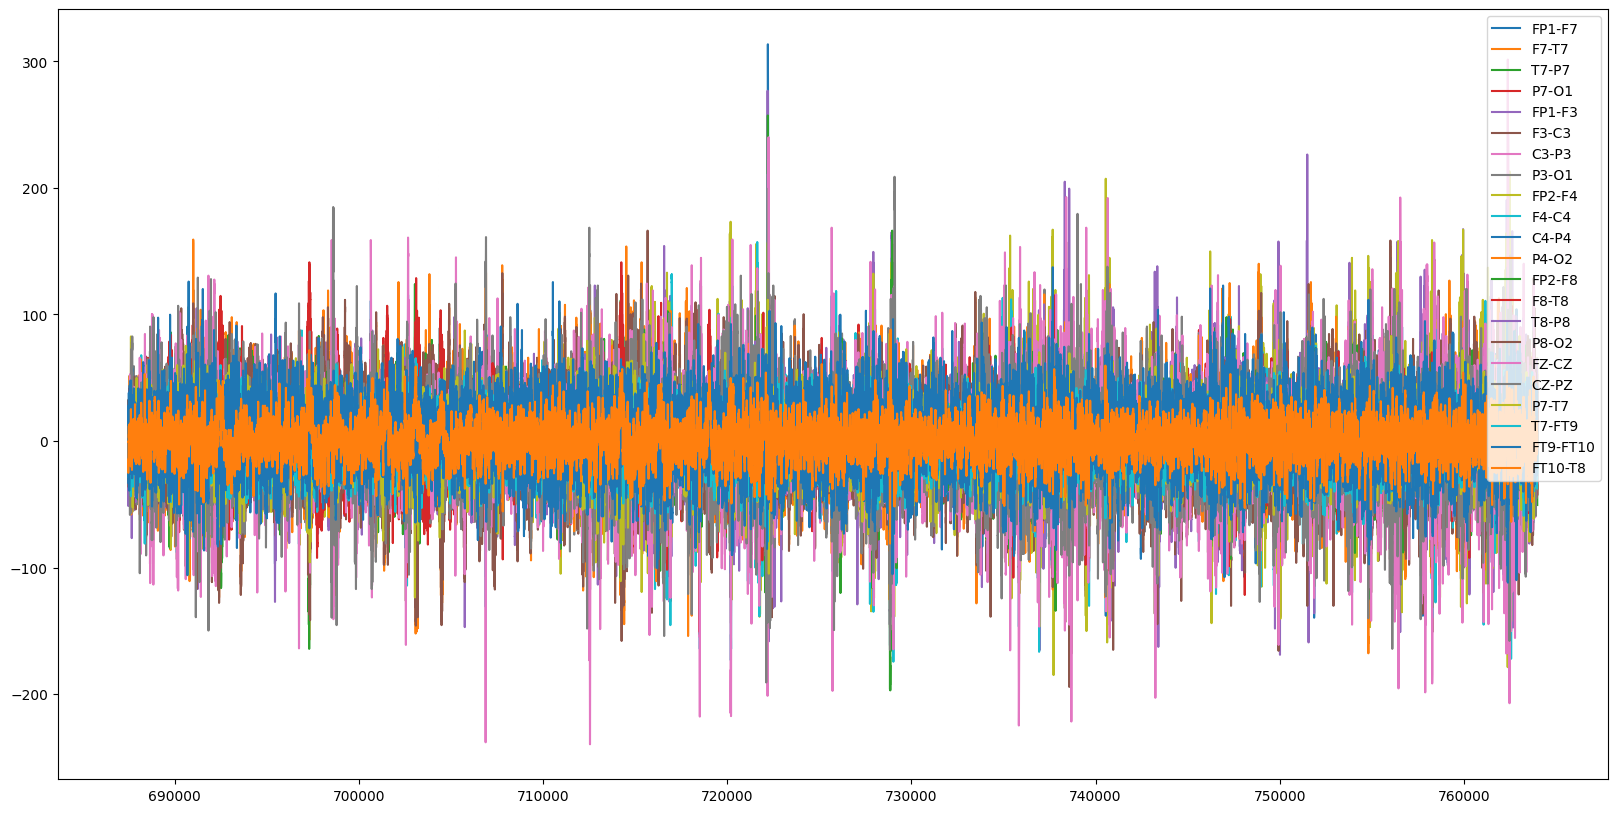

In [55]:
# plot data
preictal.plot(figsize=(20, 10))

In [56]:
# add data target to data
data["target"] = 0

# add target to preictal
data.iloc[indx_start:indx_end, -1] = 1

# subsample data by 3 using mean
data = data.groupby(np.arange(len(data))//3).mean()
data

,FP1-F7,F7-T7,T7-P7,P7-O1,FP1-F3,F3-C3,C3-P3,P3-O1,FP2-F4,F4-C4,...,F8-T8,T8-P8,P8-O2,FZ-CZ,CZ-PZ,P7-T7,T7-FT9,FT9-FT10,FT10-T8,target
0,-5.795686,13.219373,-1.107041,2.930403,-0.065120,1.497761,12.698413,-4.884005,-5.665446,-14.912495,...,-35.490435,-19.861620,60.236060,-6.056166,28.587709,1.497761,7.098087,-2.930403,-13.089133,0.0
1,-0.195360,0.716321,0.195360,-0.065120,0.195360,0.065120,-0.455840,0.846561,-0.325600,-0.325600,...,1.628002,0.586081,-1.497761,-0.195360,-0.586081,0.195360,-1.628002,0.976801,0.846561,0.0
2,0.455840,-0.455840,0.195360,0.586081,1.237281,-0.325600,0.716321,-0.976801,0.976801,0.325600,...,-1.888482,-0.976801,3.451363,0.195360,1.107041,0.195360,2.800163,-0.195360,-0.586081,0.0
3,-7.879528,6.707367,-0.455840,-2.669923,0.065120,-3.842084,-10.354090,9.312169,-6.316646,-8.400488,...,24.810745,3.581604,-42.262922,-7.098087,-11.265771,0.846561,-25.461945,13.089133,9.833130,0.0
4,-21.945462,12.047212,-1.107041,-6.967847,16.605617,-21.684982,-29.759870,16.475376,-12.047212,-25.722426,...,57.891738,-0.716321,-112.071632,-25.461945,-27.024827,1.497761,-52.942613,37.313797,20.773301,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307195,-16.084656,-53.203093,39.006919,-19.991860,46.300366,-10.614571,-61.668702,-24.680505,31.583232,-33.406593,...,44.997965,-28.587709,-100.610501,-24.810745,-95.400895,-38.616199,43.956044,31.583232,25.331705,0.0
307196,-18.819699,-48.384208,45.128205,-12.177452,37.444037,-10.875051,-41.481481,-19.731380,15.563696,-32.885633,...,42.783883,-21.294261,-83.028083,-25.461945,-73.260073,-44.737485,44.997965,25.071225,22.336182,0.0
307197,-22.857143,-40.048840,52.030932,-1.367521,29.759870,-5.535206,-20.252340,-16.735857,12.828653,-26.764347,...,43.825804,-15.042735,-53.984534,-16.866097,-49.686610,-51.640212,34.969475,28.848189,24.029304,0.0
307198,-31.452991,-36.662597,60.496540,22.075702,17.908018,-21.164021,12.828653,3.842084,17.908018,-4.493284,...,77.167277,-0.586081,-52.291412,12.958893,-32.234432,-60.105820,-1.367521,77.948718,45.649166,0.0


<AxesSubplot: >

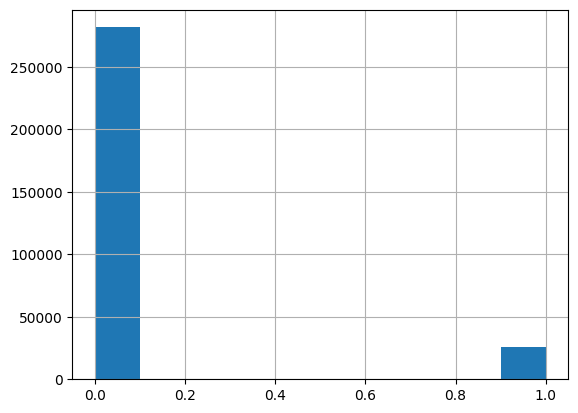

In [57]:
# histogram of target
data["target"].hist()

In [ ]:
# select random 5 minutes from target == 0
# we have 85 hz

((20400, 22), (5100, 22))

In [15]:
%%capture
%pip install tensorflow-cpu==2.10

Note: you may need to restart the kernel to use updated packages.


In [16]:
%%capture
%pip install tensorflow-directml-plugin

Note: you may need to restart the kernel to use updated packages.


In [17]:
# check if gpu is available
import tensorflow as tf
tf.test.gpu_device_name()

2023-03-08 23:40:51.658601: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-08 23:40:52.736322: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdirectml.d6f03b303ac3c4f2eeb8ca631688c9757b361310.so
2023-03-08 23:40:52.736450: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdxcore.so
2023-03-08 23:40:52.745631: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libd3d12.so
2023-03-08 23:40:54.856684: I tensorflow/c/logging.cc:34] DirectML device enumeration: found 1 compatible adapters.
2023-03-08 23:40:55.005298: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the fo

'/device:GPU:0'

In [18]:
# list gpu
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [19]:
!nvidia-smi

Wed Mar  8 23:40:56 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.46       Driver Version: 526.47       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0  On |                  N/A |
| N/A   57C    P0    21W /  N/A |    175MiB /  4096MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [30]:
# make model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv1D, MaxPooling1D

model = Sequential()

model.add(Conv1D(256, 3, input_shape=(X_train.shape[1], 1)))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(64))
model.add(Dropout(0.1))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 20, 256)           1024      
                                                                 
 activation_3 (Activation)   (None, 20, 256)           0         
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 10, 256)          0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 2560)              0         
                                                                 
 dense_2 (Dense)             (None, 64)                163904    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                      

In [21]:
%pip install pydot

Note: you may need to restart the kernel to use updated packages.


In [24]:
# !sudo apt install graphviz

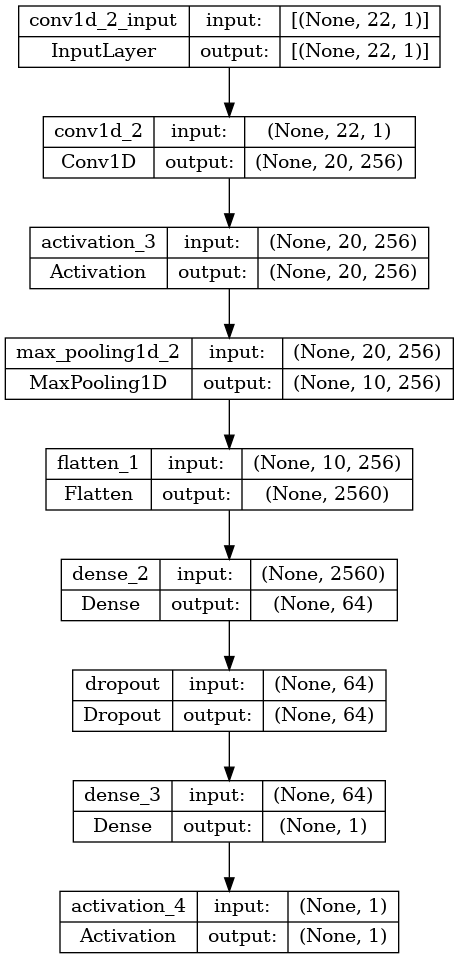

In [31]:
# draw summary
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [32]:
# train model
history = model.fit(X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1), y_train, batch_size=32, epochs=10, validation_split=0.1)

Epoch 1/10


2023-03-08 23:47:15.697025: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-08 23:47:15.766467: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-08 23:47:15.766523: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 10171 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)


574/574 [==============================] - ETA: 0s - loss: 0.0019 - accuracy: 0.9995

2023-03-08 23:47:25.358891: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-08 23:47:25.386979: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-08 23:47:25.387038: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 10171 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)


574/574 [==============================] - 10s 17ms/step - loss: 0.0019 - accuracy: 0.9995 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/10
574/574 [==============================] - 8s 14ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/10
574/574 [==============================] - 8s 14ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/10
574/574 [==============================] - 8s 15ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/10
574/574 [==============================] - 8s 14ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/10
574/574 [==============================] - 8s 15ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/10
574/574 [==============================] - 8s 14ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - v

In [28]:
# evaluate model
model.evaluate(X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1), y_test)

160/160 [==============================] - 1s 7ms/step - loss: 0.0000e+00 - accuracy: 1.0000


[0.0, 1.0]

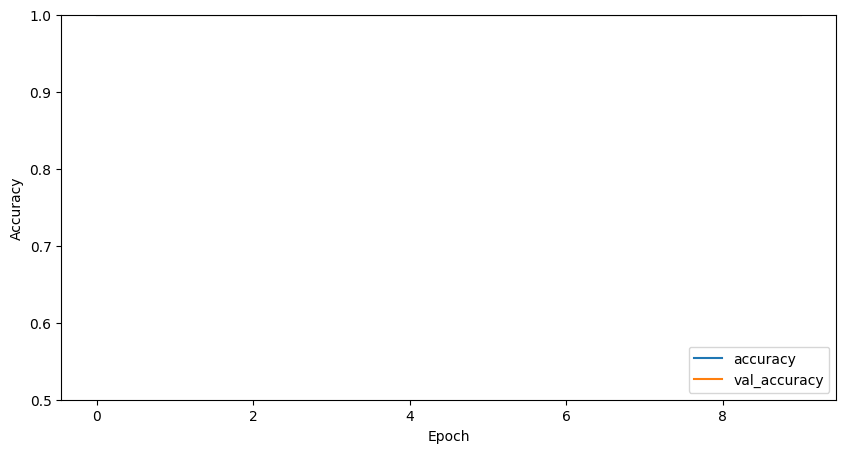

In [29]:
# plot history
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')
    plt.show()

plot_history(history)

In [39]:
# import another edf file with seizure. edfs[3] has too

edf = edfs[3]
edf

'chb01_04.edf'

In [41]:
import ast

start_end_times = seizure_data[seizure_data["file_name"] == edf]["start_end_times"].values[0]
start_time, end_time = ast.literal_eval(start_end_times)[0]

data = data_handler.get_edf_data(patient, edf)

# select features
data = data[features]

# rename T8-P8-0 to T8-P8
data = data.rename(columns={"T8-P8-0": "T8-P8"})

# select 5 minutes before start_time
# we have 255 hz

indx_start = int(start_time * 255) - 5 * 60 * 255
indx_end = int(start_time * 255)

# select data
data = data.iloc[indx_start:indx_end, :]

# check the shape
# how many minutes do we have?
data.shape[0] / 255 / 60

Extracting EDF parameters from /mnt/e/Documents/projects/seizure-prediction/data/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/home/mnsosa/projects/SeizurePrediction/src/sz_utils/data_handler.py:75: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  mne_data = mne.io.read_raw_edf(edf_path)


5.0